## Proposer une approche d’explicabilité des résultats retournés par l’Isolation Forest permettant d’analyser les variables les importantes pour la détection d’anomalies (Utilisation de la bibliothèque SHAP).

<hr>

In [1]:
import shap
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from utils import *

c:\Users\Ldech\Desktop\Travail\YNOV\M1-DATA-ENGINEERING\MACHINE LEARNING\Détection d'anomalies\TP\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Fonction pour afficher les explications SHAP
def shap_explain(model, X_train_resampled, Xtest):
    explainer = shap.TreeExplainer(model)  # Utilise TreeExplainer pour Isolation Forest
    shap_values = explainer.shap_values(Xtest)  # Calcul des valeurs SHAP pour Xtest
    shap.summary_plot(shap_values, Xtest, plot_type="bar")  # Affichage des importances des features
    shap.summary_plot(shap_values, Xtest)  # Affichage des graphiques SHAP classiques

# Fonction de scoring
def scoring(Ytest, Prob):
    precision, recall, thresholds = precision_recall_curve(Ytest, Prob)
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_idx = np.argmax(f1_scores)
    best_f1 = f1_scores[best_idx]
    best_threshold = thresholds[best_idx] if len(thresholds) > 0 else 0.5  # seuil à 0.5 de base si on ne trouve pas de meilleur seuil 
    avg_precision = average_precision_score(Ytest, Prob)
    return best_f1, avg_precision, best_threshold

In [3]:
# Charger les données
df = pd.read_csv('../data/KDDcup99.csv', sep=',')

In [4]:
df['label'] = np.where(df['label'] == 'normal', 0, 1)

In [5]:
# Séparation entre notre target 'Class' et le reste des colonnes
X = df.drop(columns=['label'])
Y = df['label']

In [6]:
X.shape, Y.shape

((494020, 41), (494020,))

In [7]:
# Extraction des anomalies
X_anomalie = X[Y == 1]
Y_anomalie = Y[Y == 1]

# Utiliser toutes les anomalies
X_anomalie_sampled = X_anomalie
Y_anomalie_sampled = Y_anomalie

X_anomalie_sampled.shape, Y_anomalie_sampled.shape

((396743, 41), (396743,))

In [8]:
# Extraction des données normales
X_normal = X[Y == 0]
Y_normal = Y[Y == 0]

# Concatenation des données normales et des anomalies
X_final = pd.concat([X_normal, X_anomalie_sampled], axis=0)
Y_final = pd.concat([Y_normal, Y_anomalie_sampled], axis=0)

# Nombre de samples et pourcentage d'anomalies
n_samples = X_final.shape
anomaly_frac = Y_final.mean()

# Affichage des informations
print(f"{n_samples} datapoints with {Y_final.sum()} anomalies ({anomaly_frac:.2%})")

# Get dummies sur nos colonnes catégorielles
X_final_encoded = pd.get_dummies(X_final, columns=['protocol_type', 'service', 'flag'])

(494020, 41) datapoints with 396743 anomalies (80.31%)


In [9]:
X_final_encoded

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,lnum_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,181,5450,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
1,0,239,486,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
2,0,235,1337,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
3,0,219,1337,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
4,0,217,2032,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490959,0,28,0,0,3,0,0,0,0,0,...,False,False,False,False,False,False,False,False,True,False
490960,0,28,0,0,3,0,0,0,0,0,...,False,False,False,False,False,False,False,False,True,False
490961,0,28,0,0,3,0,0,0,0,0,...,False,False,False,False,False,False,False,False,True,False
490962,0,28,0,0,3,0,0,0,0,0,...,False,False,False,False,False,False,False,False,True,False


In [ ]:
# Train-test split à 30%
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X_final_encoded, Y_final, test_size=0.4, stratify=Y_final, random_state=42)
# Application de Isolation Forest
model = IsolationForest(contamination='auto', n_estimators=1000, random_state=1)
model.fit(Xtrain)
Prob = -model.decision_function(Xtest)  

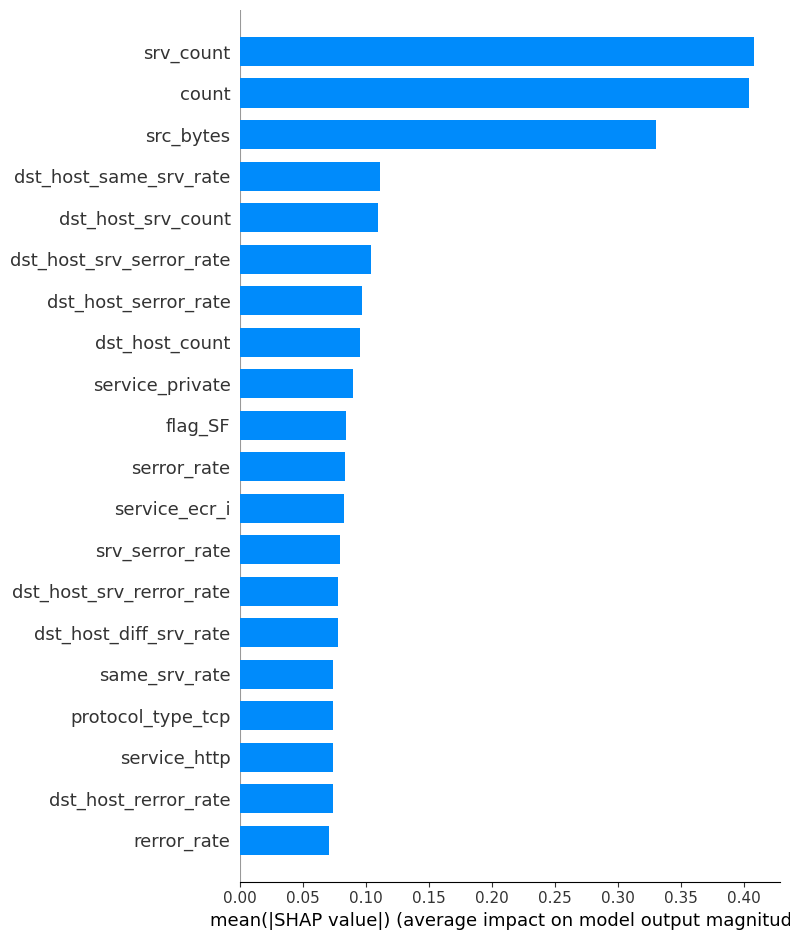

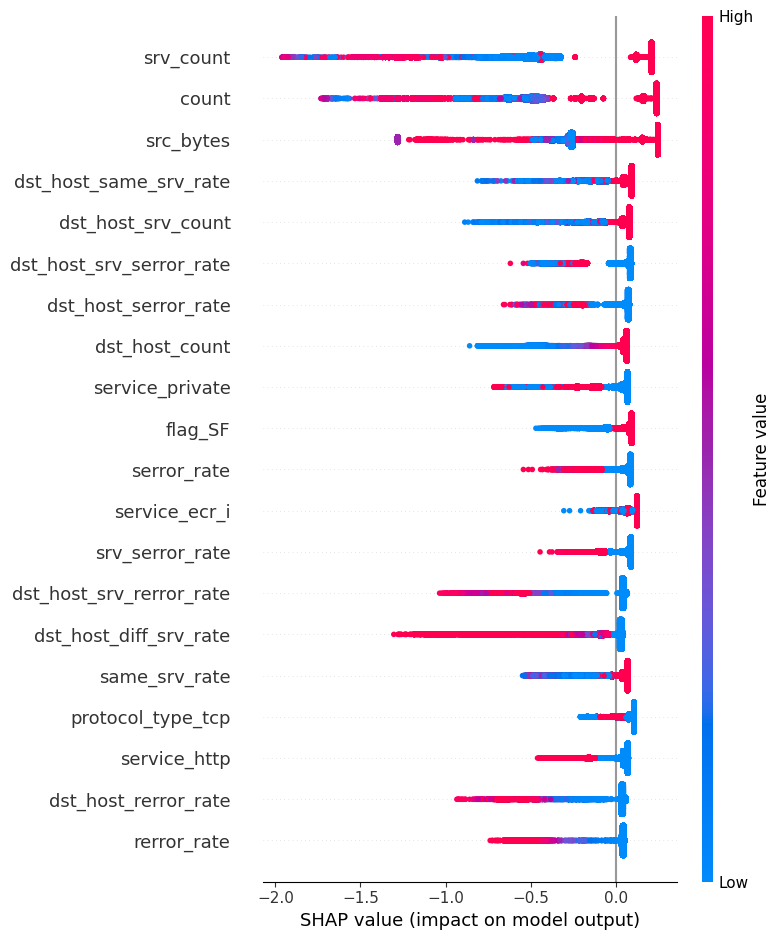

Best Model: Isolation Forest
Average Precision: 0.7073491675981702, Threshold: -0.1677912089009898


In [10]:
# Affichage des explications SHAP
shap_explain(model, Xtrain, Xtest)
# Scoring (ici on garde uniquement le score moyen de précision)
best_f1, avg_precision, best_thresh = scoring(Ytest, Prob)
print(f"Average Precision: {avg_precision}, Threshold: {best_thresh}")

<hr>

## Interprétation des résultats

##### Le graphique SHAP montre que les variables suivantes sont les plus influentes : (top 3 des variables)

- **srv_count** : Nombre de connexions vers le même service. Plus c'est élevé, plus ça peut être suspect.
- **count** : Nombre de connexions vers la même destination. Un chiffre élevé peut indiquer une attaque (par exemple, un déni de service).
- **src_bytes** : Quantité de données envoyées depuis la source. Si c'est trop bas ou trop haut, ça peut être anormal.

Exemple : 
pour srv_count, des valeurs élevées (rouge) ont un impact négatif sur la prédiction de l’anomalie (déplacement à gauche de 0 sur l'axe SHAP), ce qui peut indiquer qu’un comportement fréquent est jugé normal par le modèle. Inversement, des valeurs faibles (bleu) peuvent être perçues comme plus suspectes

<hr>